# **Stable Diffusion diversity evaluation**  


## Load packages.

In [1]:
#!pip install tensorflow==1.15.0 
#!pip install keras==2.1.6
#!pip install h5py==2.7.0 Keras==2.0.8 keras_vggface==0.3 numpy==1.13.1 imutils==0.4.3 matplotlib==2.0.2 scipy==0.19.0 Pillow==4.2.1 dlib==19.6.0 scikit_learn==0.19.

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from multiprocessing.pool import ThreadPool as Pool
import cv2
import argparse
import numpy as np
import pandas
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_hierarchical_table(table_name, prompts, modes, values_dict, error_l_dict, error_r_dict, batch_size=1, table_label='1'):
    num_modes = len(modes)
    num_prompts = len(prompts)

    latex_code = "\\begin{table*}[h]\n"
    latex_code += "\\centering\n"
    latex_code += "\\caption{" + table_name + " \\label{" + table_label + "}}\n"
    latex_code += "\\begin{tabular}{|c|" + "|".join(["c"] * (num_modes + 1)) + "|}\n"
    latex_code += "\\hline\n"
    latex_code += "\\multicolumn{1}{|c|}{Prompt} & " + " & ".join([mode.replace("_", "\\_") for mode in modes]) + " \\\\\n"
    latex_code += "\\hline\n"

    for prompt in prompts:
        prompt_lines = prompt.replace("_", "\\_").split("\\\\")

        latex_code += "\\multicolumn{1}{|c|}{"
        latex_code += "\\parbox{1.5cm}{" + prompt_lines[0] + "}"
        latex_code += "} & "

        for mode in modes:
            value = values_dict.get(prompt, {}).get(mode, "")
            error_l = error_l_dict.get(prompt, {}).get(mode, "")
            error_r = error_r_dict.get(prompt, {}).get(mode, "")

            if value == max(values_dict.get(prompt, {}).values()):
                latex_code += "\\cellcolor{lightgreen}"

            latex_code += "$" + str(round(value, 2)) + "^{+" + str(round(error_l, 2)) + "}_{-" + str(round(error_r, 2)) + "}$"

            if mode != modes[-1]:
                latex_code += " & "
    
        latex_code += " \\\\\n"
        latex_code += "\\hline\n"

    latex_code += "\\end{tabular}\n"
    latex_code += "\\end{table*}"
    return latex_code

In [3]:
def process(file):
    lines_ = []
    
    with open(file, 'r') as fe:
        for line in fe:
            lines_.append(line.strip())
            
            
    return lines_

lines = []
lines += process('myfolder/int_output.txt')
lines += process('myfolder/int_lpips_new_again.txt')
lines += process('myfolder/int_lpips_new.txt')
lines += process('myfolder/int_LPIPS.txt')
lines += process('myfolder/lpips.txt')
lines += process('myfolder/int_lpips_all.txt')
lines += process('myfolder/int_lpips_all_.txt')

ll = len(lines)

for i in range(ll):
    line = lines[i]
    pr = line.split('/private')
    if len(pr) > 2:
        for i in range(1,len(pr)):
            lines.append('/private' + pr[i])

In [5]:
def process_batch(bs):
    prompt_dic = {}
    prompt_dic_values = {}
    lf = {}
    prompt_dic_num = {}
    modes = set()
    experiments = set()
    for i in range(len(lines)):
     try:
      line = lines[i]
      if i + 1 < len(lines) and lines[i + 1].find(':') == -1:
            line += ' ' + lines[i+1]
      parts = line.split(':')
      if len(parts) > 2:
        #print(line)    
        parts = [parts[0], parts[1].split('/')[0]]

      #if len(parts) != 2:
        #print(line)
      if len(parts) == 2 and line.find('_' + str (bs)) != -1 and line.find('_' + str (bs) + '0') == -1 :
       value = min(1, float(parts[1].split(' ')[1]))
       path = parts[0]
       parts = path.split('/')
       if len(parts) >= 3:
        batch = parts[-1]
        mode = parts[-2]

        if os.path.exists(path) and batch not in experiments:
          if len(os.listdir(path)) > 2:
            prompt = parts[-3].split('mindis')[0]
            modes.add(mode)
            experiments.add(batch)
            if path.find('([3.2000])') != -1:
                prompt = prompt + '_longexp'
            elif path.find('_0_') != -1:
                prompt = prompt + '_longexp_2'
            elif path.find('([3.1000])') != -1:
                prompt = prompt + '_standardexp'
        
            if prompt not in prompt_dic:
                prompt_dic[prompt] = {}
                prompt_dic_values[prompt] = {}
                lf[prompt] = {}
                prompt_dic_num[prompt] = {}
            
            if mode not in prompt_dic_num[prompt].keys():
                prompt_dic_num[prompt][mode] = 0
                prompt_dic[prompt][mode] = 0
                prompt_dic_values[prompt][mode] = []
                
                
                
            prompt_dic[prompt][mode] += 1-value
            prompt_dic_values[prompt][mode] += [1-value]
            lf[prompt][mode] = path[:path.find(path.split('/')[-1])]

            prompt_dic_num[prompt][mode] += 1

     except:
            print('err')
    for k in prompt_dic.keys():
        for m in prompt_dic[k].keys():
            if prompt_dic[k][m] != 0:
                prompt_dic[k][m] = prompt_dic[k][m]/prompt_dic_num[k][m]
        
    return prompt_dic, prompt_dic_values, lf, prompt_dic_num, modes, experiments



def process_batch_avg(bs):
    prompt_dic = {}
    prompt_dic_values = {}
    lf = {}
    prompt_dic_num = {}
    modes = set()
    experiments = set()
    for i in range(len(lines)):
     try:
      line = lines[i]
      if i + 1 < len(lines) and lines[i + 1].find(':') == -1:
            line += ' ' + lines[i+1]
      parts = line.split(':')
      if len(parts) > 2:
        #print(line)    
        parts = [parts[0], parts[1].split('/')[0]]

      #if len(parts) != 2:
        #print(line)
      if len(parts) == 2 and line.find('_' + str (bs)) != -1 and line.find('_' + str (bs) + '0') == -1 :
       value = min(1, float(parts[1].split(' ')[1]))
       path = parts[0]
       parts = path.split('/')
       if len(parts) >= 3:
        batch = parts[-1]
        mode = parts[-2]

        if os.path.exists(path) and batch not in experiments:
          if len(os.listdir(path)) > 2:
            prompt = parts[-3].split('mindis')[0]
            modes.add(mode)
            experiments.add(batch)
            if path.find('([3.2000])') != -1:
                prompt = prompt + '_longexp'
            elif path.find('_0_') != -1:
                prompt = prompt + '_longexp_2'
            elif path.find('([3.1000])') != -1:
                prompt = prompt + '_standardexp'
        
            if prompt not in prompt_dic:
                prompt_dic[prompt] = {}
                prompt_dic_values[prompt] = {}
                lf[prompt] = {}
                prompt_dic_num[prompt] = {}
            
            if mode not in prompt_dic_num[prompt].keys():
                prompt_dic_num[prompt][mode] = 0
                prompt_dic[prompt][mode] = 0
                prompt_dic_values[prompt][mode] = []
                
                
                
            prompt_dic[prompt][mode] += 1-value
            prompt_dic_values[prompt][mode] += [1-value]
            lf[prompt][mode] = path[:path.find(path.split('/')[-1])]

            prompt_dic_num[prompt][mode] += 1

     except:
            print('err')
    for k in prompt_dic.keys():
        for m in prompt_dic[k].keys():
            if prompt_dic[k][m] != 0:
                prompt_dic[k][m] = prompt_dic[k][m]/prompt_dic_num[k][m]
        
    return prompt_dic, prompt_dic_values, lf, prompt_dic_num, modes, experiments

In [33]:
sum_lpips = 0
num_lpips = 0


for p in prompt_dic.keys():
        m = 'f_mod_cap_pooling'
        sum_lpips += prompt_dic[p][m] * prompt_dic_num[p][m]
        num_lpips += prompt_dic_num[p][m]
        
avg_lpips = sum_lpips/num_lpips
avg_lpips

0.33472429030291845

In [34]:
sum_lpips = 0
num_lpips = 0
for p in prompt_dic.keys():
        m = 'f_mod'
        sum_lpips += prompt_dic[p][m] * prompt_dic_num[p][m]
        num_lpips += prompt_dic_num[p][m]
        
avg_lpips = sum_lpips/num_lpips
avg_lpips

0.35671103465339277

In [6]:
def compute_error(values, _):
    num_batches = len(list(values))
    print(num_batches)
    return np.std(values)/np.sqrt(num_batches)*3.29, np.std(values)/np.sqrt(num_batches)*3.29

def split_title(title, sp_size = 80):
    # Split the title into two lines if it exceeds the plot width
    tt = title
    while len(tt) > sp_size:
        split_idx = tt[:sp_size].rfind(' ')  # Find the last space within the limit
     # If no space found, split at the exact position
        if split_idx == -1:
            split_idx = sp_size
        title = title[:-len(tt)] + tt[:split_idx] + '\n' + tt[split_idx+1:]
        tt = title.split('\n')[-1]
    return title

def get_graph(bs, prompt_dic, prompt_dic_values, prompt_dic_num, lf_dic, num_modes, modes, sd=None, title='Percentages obtained in different modes', updated_experiment=False):
    if updated_experiment == True:
        title += ', long experiment'
    else:
        title += ', standard experiment'
    if len(title) > 80:
        title = split_title(title)
    pr = []
    ks = []
    ms = sorted(list(modes))

    if bs == 10:
        v = 1500
    if bs == 5:
        v = 3000
    if bs == 3:
        v = 7000
    if bs == 50:
        v = 600
    num_prompts = 0
    for k in sorted(list(prompt_dic.keys())):
        flag = True
        if k not in prompt_dic_num.keys():
            prompt_dic_num[k] = {}
        if k not in lf_dic.keys():
            lf_dic[k] = {}            
        if k not in prompt_dic_values.keys():
            prompt_dic_values[k] = {}      
        for m in ms:
            if m not in prompt_dic[k].keys() or m not in prompt_dic_values[k].keys():
                prompt_dic[k][m] = 0
                prompt_dic_num[k][m] = 0
                prompt_dic_values[k][m] = []
                flag = False
            elif (len(prompt_dic_values[k][m])) <= v:
                flag = False
                
        if flag:
            if (k.find('_longexp') != -1 and updated_experiment == True) or updated_experiment == None:
                ks.append(k)
                num_prompts += 1

            if (k.find('_standardexp') != -1 and updated_experiment == False) or updated_experiment == None:
                ks.append(k)
                num_prompts += 1

    p = []
    for k in ks:
        if k == 'a professional photograph of an adult person face_longexp':
            p.append('photo_longexp')
        elif k == 'a professional photograph of an adult person face_standardexp':
            p.append('photo_standardexp')
        elif k == "photo of an animal in the grass_longexp":
            p.append("animal_longexp")
        elif k == "photo of an animal in the grass_standardexp":
            p.append("animal_standardexp")
        elif k == "octane, hyperrealistic, backlit_longexp":
            p.append("octane_longexp")
        elif k == "octane, hyperrealistic, backlit_standardexp":
            p.append("octane_standardexp")
        else:
            p.append(k)

    if updated_experiment == True:
        for i in range(len(p)):
            pr.append(p[i].split('_longexp')[0])
    if updated_experiment == False:
        for i in range(len(p)):
            pr.append(p[i].split('_standardexp')[0])

    w = 0.5
    first_tick = int(math.ceil((num_modes * w / 2)))
    gap = num_modes * w + 1
    x = np.array([first_tick + i * gap for i in range(num_prompts)])

    # Use a distinct seaborn color palette for each mode
    colors = sns.color_palette('ocean', num_modes+1)[1:]
    for i in range(len(ms)):
        if ms[i] == 'f_mod':
            colors[i] = (0,0,0)
        if ms[i] == 'f_mod_cap_pooling':
            colors[i] = (1,0,0)
    plt.rcParams.update({'font.size': 26})

    fig, ax = plt.subplots(1, 1, figsize=(8, num_prompts * 1.2))
    ax.yaxis.grid(False)

    b = []

    for i in range(len(ms)):
        for k in ks:
            if ms[i] not in prompt_dic[k].keys():
                prompt_dic[k][ms[i]] = -1
                prompt_dic_num[k][ms[i]] = 1
                lf_dic[k][ms[i]] = -1
            if ms[i] not in lf_dic[k]:
                lf_dic[k][ms[i]] = ''
        b.append(ax.barh(x - (i - num_modes / 2 + 0.5) * w,[prompt_dic[k][ms[i]] for k in ks],
                    height=w,
                    color=colors[i],
                    align='center',
                    edgecolor='black',
                    linewidth=1.0,
                    alpha=0.5))

    modes_list = []

    for m in ms:
        if m == 'f_mod':
            modes_list.append('baseline')
        elif m == 'f_mod_cap':
            modes_list.append('cap')
        elif m == 'f_mod_max_pooling':
            modes_list.append('pooling_max')
        elif m == 'f_mod_cap_pooling':
            modes_list.append('pooling_cap')
        elif m == 'f_mod_max':
            modes_list.append('min')
        elif m == 'f_mod_max_real':
            modes_list.append('max')
        else:
            modes_list.append(m)

    br = []
    x_new = []
    br_dic = {}

    for i in range(len(ms)):
        x_new += list(x - (i - num_modes / 2 + 0.5) * w)
        for k in ks:
            if ms[i] in prompt_dic[k].keys():
                br_el = prompt_dic[k][ms[i]]
                br.append(br_el)
                br_dic[len(br) - 1] = ms[i]
            else:
                br.append(0)
                br_dic[0] = ms[i]
                prompt_dic[k][ms[i]] = 0

    error_l = [compute_error(prompt_dic_values[k][m], bs)[0] for m in ms for k in ks]
    error_r = [compute_error(prompt_dic_values[k][m], bs)[1] for m in ms for k in ks]
    
    print()
    print('error_l')
    print(error_l)
    print()
    print('error_r')
    print(error_r)

    if sd is not None:
        error_l = [sd[k][m] for m in ms for k in ks]
        error_r = [sd[k][m] for m in ms for k in ks]

    error = np.zeros((2, len(error_l)))

    for i in range(len(error_l)):
        error[0][i] = error_l[i]
        error[1][i] = error_r[i]

    # Draw line segments and dots for each mode
    for i, color in enumerate(colors):
        for j in range(len(ks)):
            x_val = x[j] - (i - num_modes / 2 + 0.5) * w
            y_val = br[j + len(ks) * i]
            error_left = error[0][j + len(ks) * i]
            error_right = error[1][j + len(ks) * i]

            # Draw the line segment
    ax.errorbar(br, x_new, xerr=error, fmt='none')
    ax.set_xlabel('Average LPIPS value')
    ax.set_ylabel('Modes')
    ax.set_title(title)
    ax.set_yticks(x)
    ax.set_yticklabels([split_title(p.replace('_', ' '), 15) for p in pr])
    ax.legend([b_ for b_ in b], modes_list, ncol=3, loc='best', framealpha=0.1)

    ax.set_xlim(min(br) - max(error_l))
    
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})



    plt.savefig('graphs/' + title.replace('\n',' ').replace('.', ',').replace('Percentage of image batches of', 'percent')
                .replace('that contain images with dominance of different colors (at least 2 from 3)', '2inRGB')
                .replace('contain images', ''))

    plt.show()
    
    
    
def get_graph(bs, prompt_dic, prompt_dic_values, prompt_dic_num, lf_dic, num_modes, modes, sd=None, title='Percentages obtained in different modes', updated_experiment=False):
    if updated_experiment:
        title += ', long experiment'
    else:
        title += ', standard experiment'
    if len(title) > 80:
        title = split_title(title)
        
    pr = []
    ks = []
    ms = sorted(list(modes))

    if bs == 10:
        v = 1500
    if bs == 5:
        v = 3000
    if bs == 3:
        v = 7000
    if bs == 50:
        v = 600
    
    num_prompts = 0
    for k in sorted(list(prompt_dic.keys())):
        flag = True
        if k not in prompt_dic_num.keys():
            prompt_dic_num[k] = {}
        if k not in lf_dic.keys():
            lf_dic[k] = {}            
        if k not in prompt_dic_values.keys():
            prompt_dic_values[k] = {}      
        for m in ms:
            if m not in prompt_dic[k].keys() or m not in prompt_dic_values[k].keys():
                prompt_dic[k][m] = 0
                prompt_dic_num[k][m] = 0
                prompt_dic_values[k][m] = []
                flag = False
            elif (len(prompt_dic_values[k][m])) <= v:
                flag = False
                
        if flag:
            if (k.find('_longexp') != -1 and updated_experiment) or updated_experiment is None:
                ks.append(k)
                num_prompts += 1

            if (k.find('_standardexp') != -1 and not updated_experiment) or updated_experiment is None:
                ks.append(k)
                num_prompts += 1

    p = []
    for k in ks:
        if k == 'a professional photograph of an adult person face_longexp':
            p.append('photo_longexp')
        elif k == 'a professional photograph of an adult person face_standardexp':
            p.append('photo_standardexp')
        elif k == "photo of an animal in the grass_longexp":
            p.append("animal_longexp")
        elif k == "photo of an animal in the grass_standardexp":
            p.append("animal_standardexp")
        elif k == "octane, hyperrealistic, backlit_longexp":
            p.append("octane_longexp")
        elif k == "octane, hyperrealistic, backlit_standardexp":
            p.append("octane_standardexp")
        else:
            p.append(k)

    if updated_experiment:
        pr = [p[i].split('_longexp')[0] for i in range(len(p))]
    else:
        pr = [p[i].split('_standardexp')[0] for i in range(len(p))]

    w = 0.5
    first_tick = int(math.ceil((num_modes * w / 2)))
    gap = num_modes * w + 1
    x = np.array([first_tick + i * gap for i in range(num_prompts)])

    # Use a distinct seaborn color palette for each mode
    colors = sns.color_palette('ocean', num_modes+1)[1:]
    for i in range(len(ms)):
        if ms[i] == 'f_mod':
            colors[i] = (0, 0, 0)
        if ms[i] == 'f_mod_cap_pooling':
            colors[i] = (1, 0, 0)

    plt.rcParams.update({'font.size': 18})

    fig, ax = plt.subplots(1, 1, figsize=(14, num_prompts * 1.2))

    ax.yaxis.grid(False)

    b = []
    for i in range(len(ms)):
        for k in ks:
            if ms[i] not in prompt_dic[k].keys():
                prompt_dic[k][ms[i]] = -1
                prompt_dic_num[k][ms[i]] = 1
                lf_dic[k][ms[i]] = -1
            if ms[i] not in lf_dic[k]:
                lf_dic[k][ms[i]] = ''
        b.append(ax.barh(x - (i - num_modes / 2 + 0.5) * w, [prompt_dic[k][ms[i]] for k in ks],
                         height=w,
                         color=colors[i],
                         align='center',
                         edgecolor='black',
                         linewidth=1.0,
                         alpha=0.5))

    modes_list = []
    for m in ms:
        if m == 'f_mod':
            modes_list.append('baseline')
        elif m == 'f_mod_cap':
            modes_list.append('cap')
        elif m == 'f_mod_max_pooling':
            modes_list.append('pooling_max')
        elif m == 'f_mod_cap_pooling':
            modes_list.append('pooling_cap')
        elif m == 'f_mod_max':
            modes_list.append('min')
        elif m == 'f_mod_max_real':
            modes_list.append('max')
        else:
            modes_list.append(m)

    br = []
    x_new = []
    br_dic = {}

    for i in range(len(ms)):
        x_new += list(x - (i - num_modes / 2 + 0.5) * w)
        for k in ks:
            if ms[i] in prompt_dic[k].keys():
                br_el = prompt_dic[k][ms[i]]
                br.append(br_el)
                br_dic[len(br) - 1] = ms[i]
            else:
                br.append(0)
                br_dic[0] = ms[i]
                prompt_dic[k][ms[i]] = 0

    error_l = [compute_error(prompt_dic_values[k][m], bs)[0] for m in ms for k in ks]
    error_r = [compute_error(prompt_dic_values[k][m], bs)[1] for m in ms for k in ks]

    if sd is not None:
        error_l = [sd[k][m] for m in ms for k in ks]
        error_r = [sd[k][m] for m in ms for k in ks]

    error = np.zeros((2, len(error_l)))

    for i in range(len(error_l)):
        error[0][i] = error_l[i]
        error[1][i] = error_r[i]

    # Draw line segments and dots for each mode
    for i, color in enumerate(colors):
        for j in range(len(ks)):
            x_val = x[j] - (i - num_modes / 2 + 0.5) * w
            y_val = br[j + len(ks) * i]
            error_left = error[0][j + len(ks) * i]
            error_right = error[1][j + len(ks) * i]

    ax.errorbar(br, x_new, xerr=error, fmt='none')
    ax.set_xlabel('Average LPIPS value')
    ax.set_ylabel('Modes')
    ax.set_title(title)
    ax.set_yticks(x)
    ax.set_yticklabels([split_title(p.replace('_', ' '), 25) for p in pr])

    # Move the legend under the graph
    ax.legend([b_ for b_ in b], modes_list, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.1), framealpha=0.1)

    ax.set_xlim(min(br) - max(error_l), max(br) + max(error_r))

    plt.tight_layout()


    plt.savefig('graphs/' + title.replace('\n',' ').replace('.', ',').replace('Percentage of image batches of', 'percent').replace('that contain images with dominance of different colors (at least 2 from 3)', '2inRGB').replace('contain images', ''))

    plt.show()

In [7]:
!mkdir graphs

mkdir: cannot create directory ‘graphs’: File exists


# K = 1
## batch size = 50

In [ ]:
bs = 50
prompt_dic, prompt_dic_values, lf, prompt_dic_num, modes, experiments = process_batch(bs)

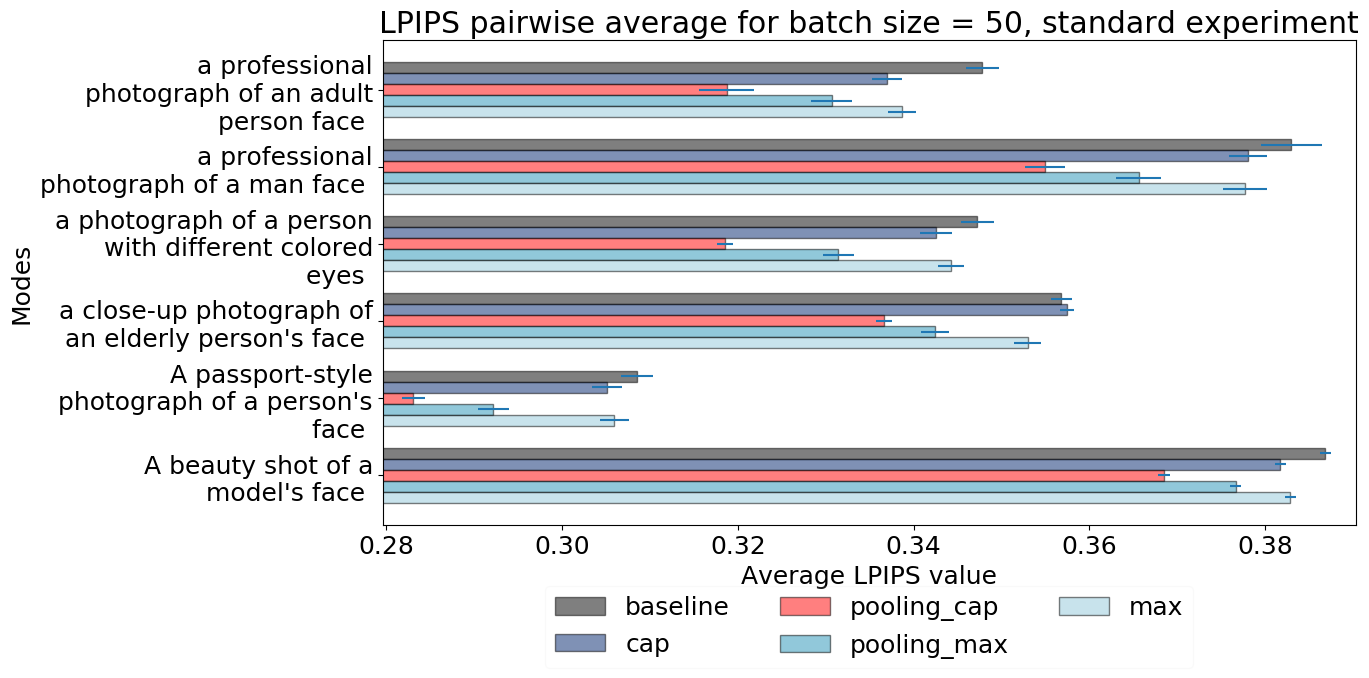

In [9]:
get_graph(bs, prompt_dic, prompt_dic_values, prompt_dic_num, lf, len(modes), modes, sd = None,  title = 'LPIPS pairwise average for batch size = ' + str(bs), updated_experiment = False)

In [10]:
print([k.split('__')[0] for k in prompt_dic.keys()])

['a professional photograph of a man face', 'a photograph of a person with different colored eyes', "A passport-style photograph of a person's face", 'a professional photograph of an adult person face', "a close-up photograph of an elderly person's face", "A beauty shot of a model's face", 'rose', 'horse', 'horse', 'butterfly', 'ornament', 'butterfly', 'ornament', 'octane, hyperrealistic, backlit', 'photo of an animal in the grass', 'color', 'color', 'cat', 'car', 'face', 'face', 'car', 'photo of an animal in the grass', 'a professional photograph of an adult person face', 'bird', 'rose', 'cat', 'bird', 'octane, hyperrealistic, backlit']


In [ ]:
# Sample data
table_name = "Average batch pairwise LPIPS distance"
prompts = []
for k in prompt_dic.keys():
    if 'photo' in k:
        prompts.append(k)

# Sample data
values_dict = prompt_dic

error_dict_l = {}
error_dict_r = {}

for k in prompts:
    error_dict_l[k] = {}
    error_dict_r[k] = {}

    for m in modes:
        if m in prompt_dic_num[k].keys():
            error_dict_l[k][m] = compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[0]
            error_dict_r[k][m] = compute_error(prompt_dic[k][m], prompt_dic_num[k][m])[1]

        else: 
            error_dict_l[k][m] = 0 
            error_dict_r[k][m] = 0

# Generate hierarchical table
latex_table = generate_hierarchical_table(table_name, prompts, list(modes), values_dict, error_dict_l, error_dict_r)

# Print the LaTeX table
print(latex_table)

# K = 1
## batch size = 3

In [ ]:
bs_3 = 3
prompt_dic_3, prompt_dic_values_3, lf_3, prompt_dic_num_3, modes_3, experiments_3= process_batch(bs_3)

9162
8901
9446
8829
8819
9049
9012
9155
9938
9224
10082
9186
8987
9367
10198
9088
9213
9404
9259
9864
9264
9719
9286
9476
8804
9036
9433
9003
8964
9216
9112
9182
8766
9279
8774
9033
7619
8233
8373
8688
8561
8325
8561
8171
7666
8713
8249
8554
7944
8355
8399
8533
8531
8379
8501
8443
8023
8656
7676
7981
9162
8901
9446
8829
8819
9049
9012
9155
9938
9224
10082
9186
8987
9367
10198
9088
9213
9404
9259
9864
9264
9719
9286
9476
8804
9036
9433
9003
8964
9216
9112
9182
8766
9279
8774
9033
7619
8233
8373
8688
8561
8325
8561
8171
7666
8713
8249
8554
7944
8355
8399
8533
8531
8379
8501
8443
8023
8656
7676
7981


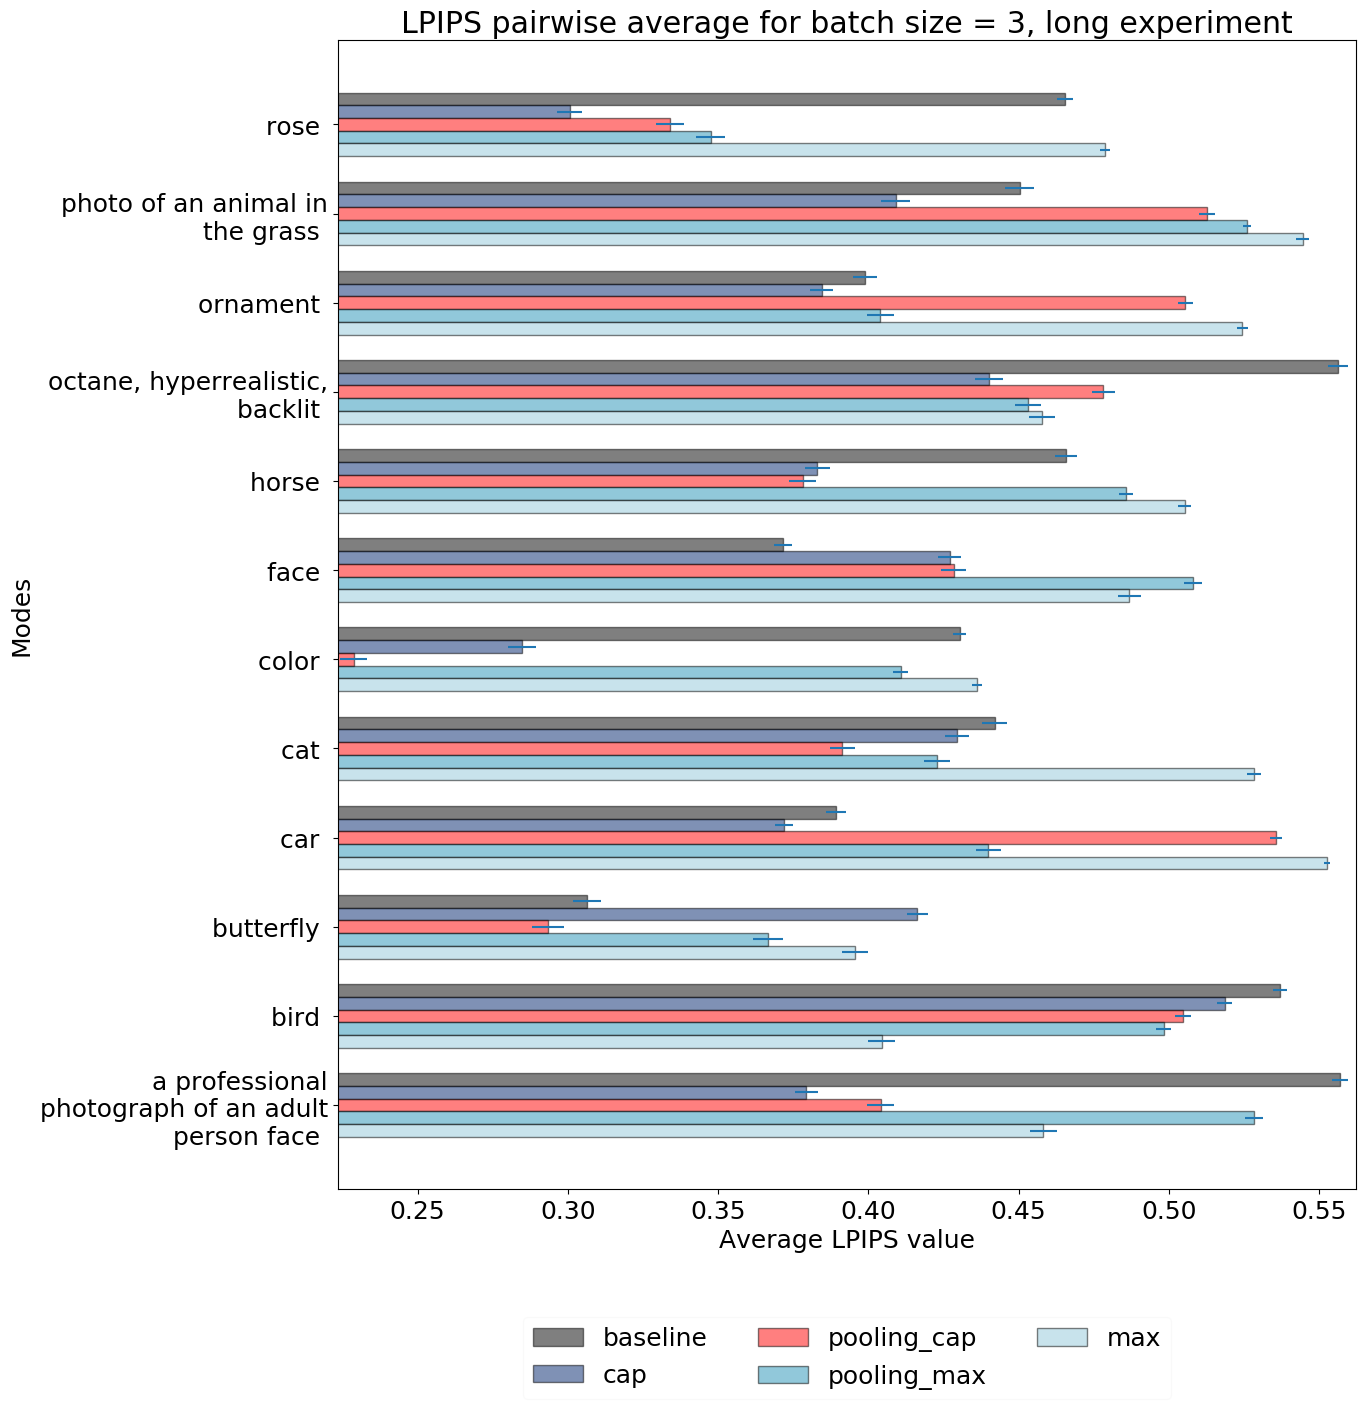

In [19]:
get_graph(bs_3, prompt_dic_3, prompt_dic_values_3, prompt_dic_num_3, lf_3, len(modes_3), modes_3, sd = None,  title = 'LPIPS pairwise average for batch size = ' + str(bs_3), updated_experiment = True)

# K = 1
## batch size = 5

In [ ]:
bs_5 = 5
prompt_dic_5, prompt_dic_values_5, lf_5, prompt_dic_num_5, modes_5, experiments_5= process_batch(bs_5)

4799
4692
5055
4791
4596
4707
4681
4650
5233
4861
5451
4788
4657
4909
5246
5341
4985
4820
4699
5598
4693
5045
4975
5114
4620
5051
5132
4837
4924
5523
5433
5052
4570
5220
4448
4914
3737
3646
4162
3868
3760
4243
3823
4326
4095
4283
3347
3725
3869
4051
3743
3928
3590
3943
3789
4010
3662
4340
3547
3938
4799
4692
5055
4791
4596
4707
4681
4650
5233
4861
5451
4788
4657
4909
5246
5341
4985
4820
4699
5598
4693
5045
4975
5114
4620
5051
5132
4837
4924
5523
5433
5052
4570
5220
4448
4914
3737
3646
4162
3868
3760
4243
3823
4326
4095
4283
3347
3725
3869
4051
3743
3928
3590
3943
3789
4010
3662
4340
3547
3938


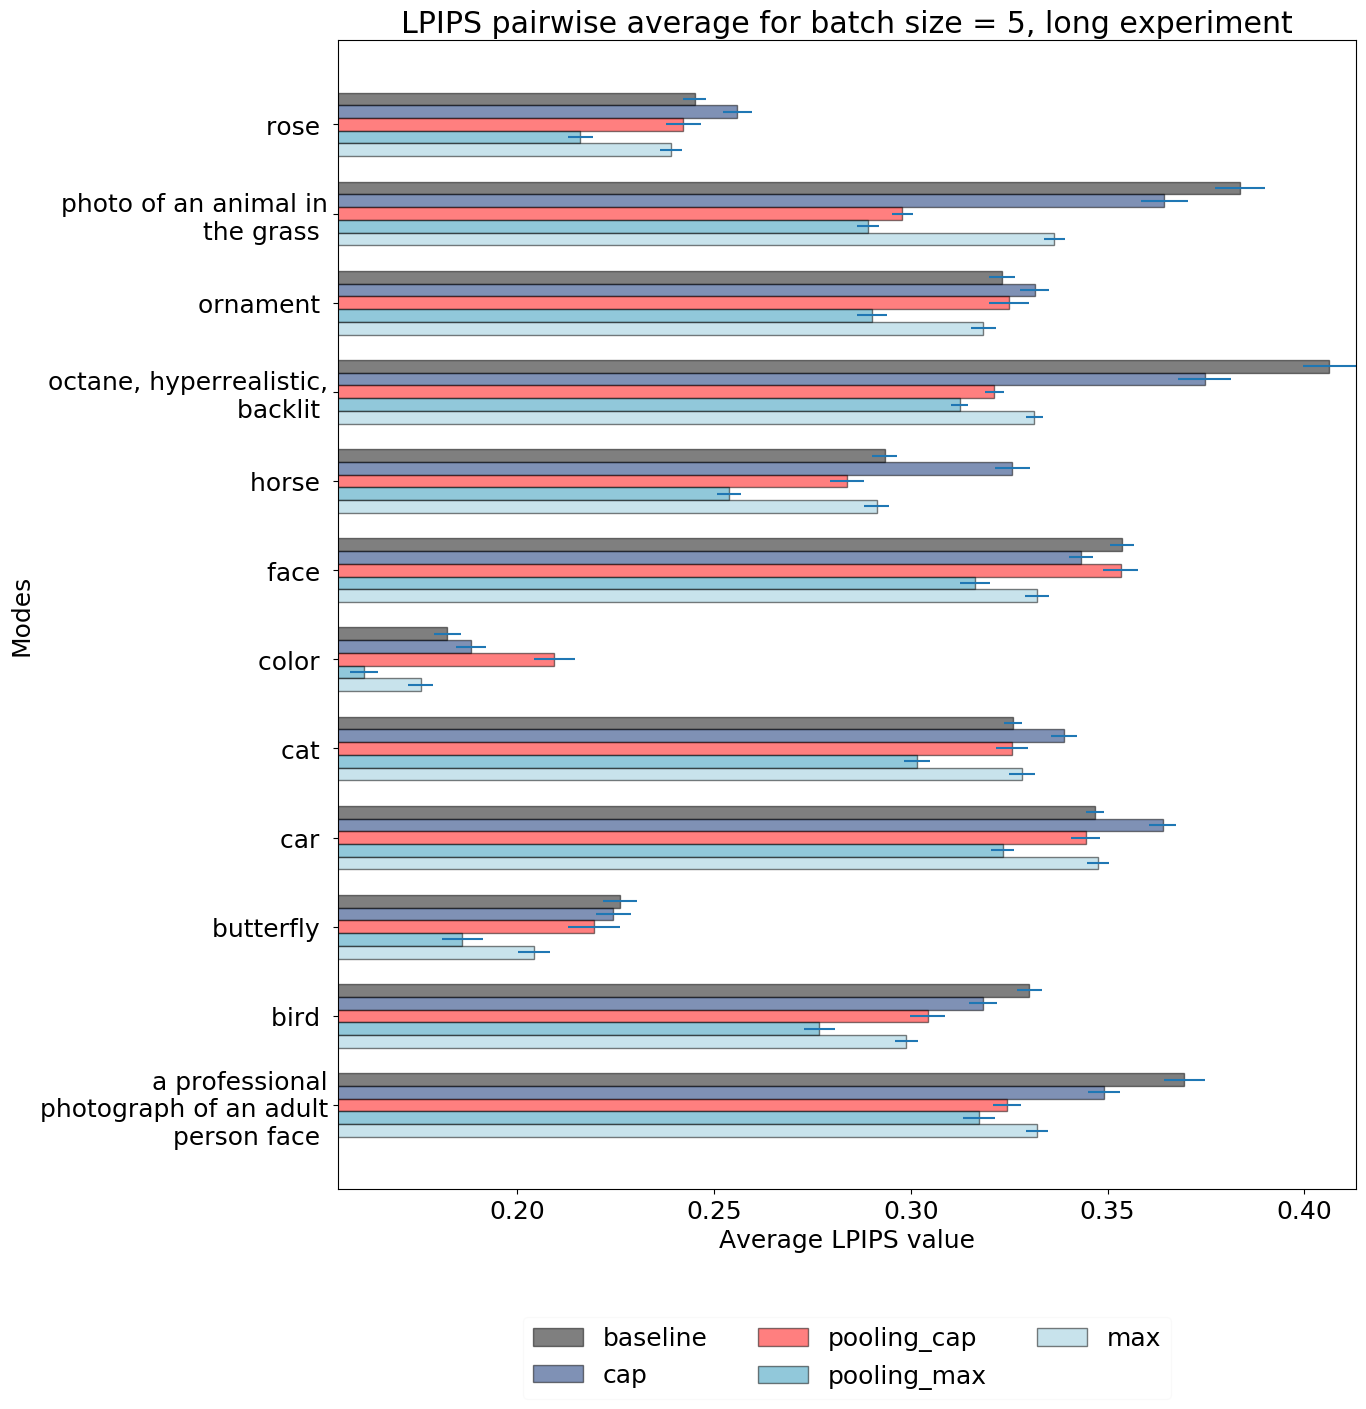

In [20]:
get_graph(bs_5, prompt_dic_5,  prompt_dic_values_5, prompt_dic_num_5, lf_5, len(modes_5), modes_5, sd = None,  title = 'LPIPS pairwise average for batch size = ' + str(bs_5), updated_experiment = True)

# K = 1
## batch size = 10

In [ ]:
bs_10 = 10
prompt_dic_10, prompt_dic_values_10, lf_10, prompt_dic_num_10, modes_10, experiments_10= process_batch(bs_10)

3397
3456
3292
3118
3175
3385
3471
3182
3359
3258
3560
3595
3567
3336
3364
3179
3706
2852
3538
3409
2283
2414
2756
2369
2766
2639
3100
2295
2676
3079
1944
2150
2678
2021
1817
1762
2259
1868
2299
2511
1813
1690
2245
1871
1891
1646
2123
1580
1822
2438
3397
3456
3292
3118
3175
3385
3471
3182
3359
3258
3560
3595
3567
3336
3364
3179
3706
2852
3538
3409
2283
2414
2756
2369
2766
2639
3100
2295
2676
3079
1944
2150
2678
2021
1817
1762
2259
1868
2299
2511
1813
1690
2245
1871
1891
1646
2123
1580
1822
2438


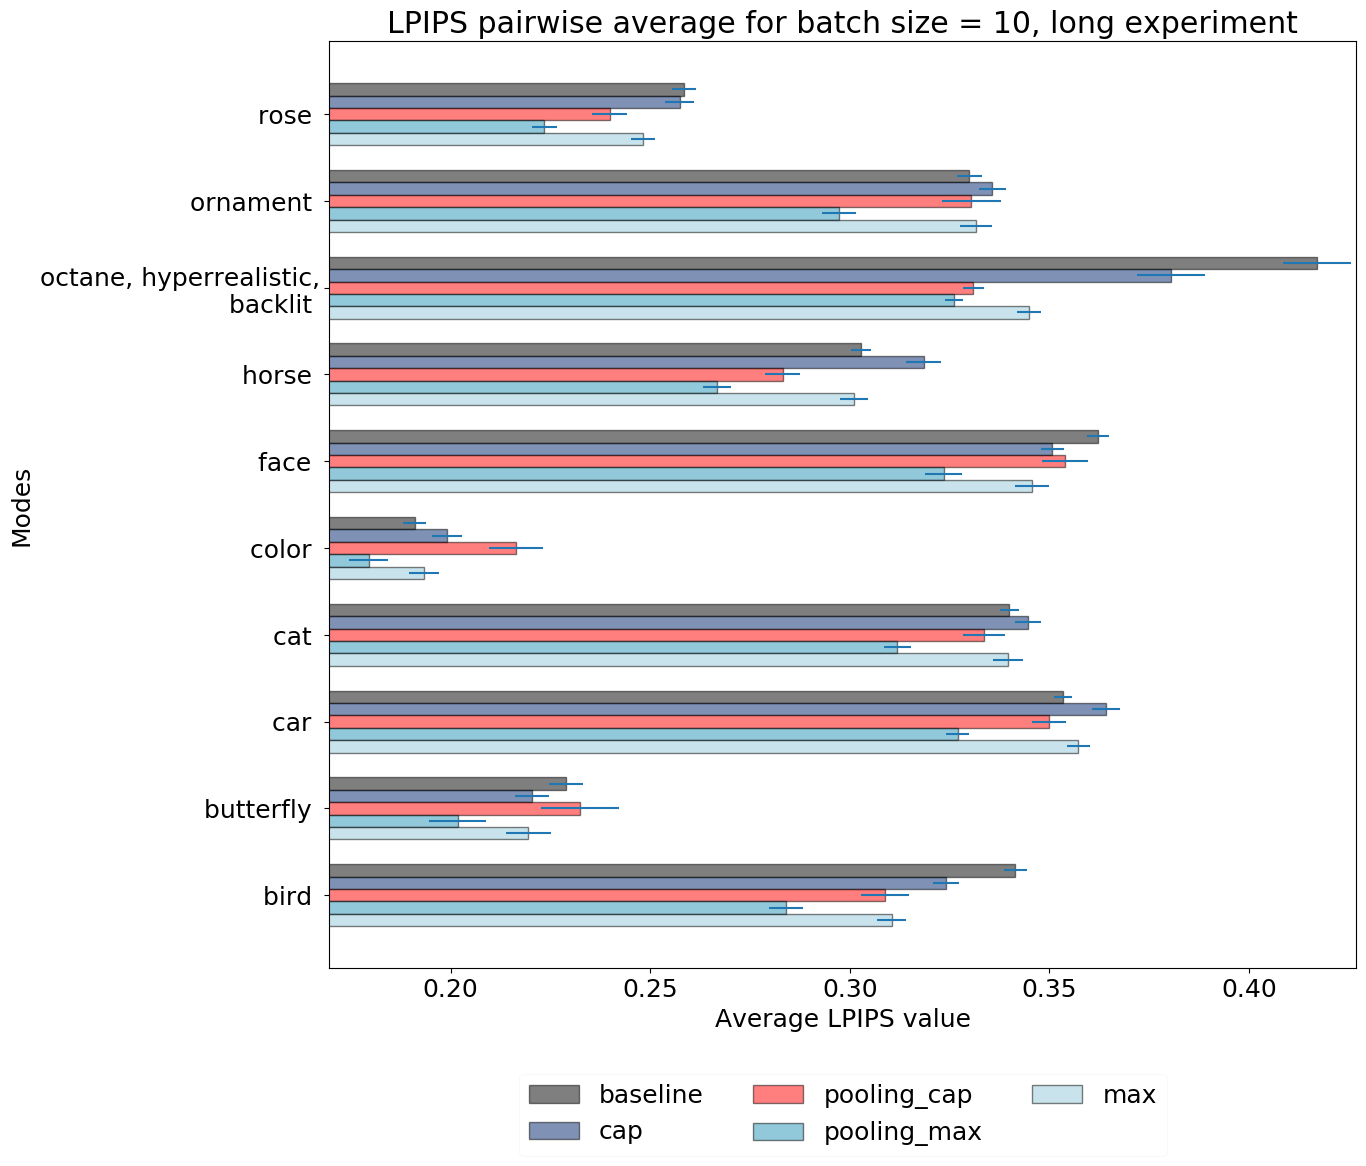

In [21]:
get_graph(bs_10, prompt_dic_10, prompt_dic_values_10, prompt_dic_num_10, lf_10, len(modes_10), modes_10, sd = None,  title = 'LPIPS pairwise average for batch size = ' + str(bs_10), updated_experiment = True)

# Average LPIPS value 
## for all the images generated with specific mode across different prompts: comparing our results with other diversity-focused experiments

In [ ]:
import lpips 
import torch
from PIL import Image
from joblib import Parallel, delayed
import math          
import torchvision.transforms as transforms
import glob
from tqdm import tqdm
from pathlib import Path


loss_fn = lpips.LPIPS(net='vgg')
img_paths_dic = {}

In [240]:
def load_image(path):
    with Image.open(path) as image:
        image = image.convert('RGB')
    return transforms.ToTensor()(image)

def calculate_lpips_distance(images):
    img1, img2 = images[0].to(torch.device("cpu")), images[1].to(torch.device( "cpu"))
    distance = loss_fn(img1, img2).item()
    return 1 - distance



def get_image_paths(folder_path, pattern, mode, num_samples=100000):
    cache_key = pattern + mode
    if cache_key in img_paths_dic.keys():
           return img_paths_dic[cache_key]

    image_paths = []
    total_files = 0

    with tqdm(total=num_samples, desc='Progress', unit='file') as pbar:
        for _ in range(num_samples):
            r = random.choice(os.listdir(folder_path))
            pbar.update(1)
            entry = os.path.join(folder_path, r)
            entry = os.path.join(entry, mode)
            if pattern in entry:
                r_folder = random.choice(os.listdir(entry))
                rr = os.path.join(entry, r_folder)
                if len(os.listdir(rr)) != 0:
                    r_image = random.choice(os.listdir(rr))
                    image_paths.append(os.path.join(rr, r_image))

    random.shuffle(image_paths)
    img_paths_dic[cache_key] = image_paths
    return image_paths

def get_matching_path(path, image_paths):
    path_parts = os.path.normpath(path).split(os.path.sep)
    folder_parts = path_parts[:-2]  # Exclude the image and its folder from the folder parts
    folder_path = os.path.join(*folder_parts)

    matching_paths = [img_path for img_path in image_paths if folder_path in img_path]
    return random.choice(matching_paths)

def random_lpips_comparison(mode='f_mod', pattern='([3.1000])_batch_50', num_experiments=1000):
    dist = 0.0
    dist_sq = 0.0
    image_folder_path = 'myfolder/FACE/stable-diffusion/ee'  # Provide the path to the folder containing images
    image_paths = get_image_paths(image_folder_path, pattern, mode)

    with tqdm(total=num_experiments, desc='Calculating LPIPS', unit='experiment') as pbar:
        for _ in range(num_experiments):
            # Select two random image paths
            img_path_1 = random.choice(image_paths)
            img_path_2 = get_matching_path(img_path_1, image_paths)

            # Calculate the LPIPS distance between the images
            dist += calculate_lpips_distance([load_image(img_path_1), load_image(img_path_2)])
            dist_sq += calculate_lpips_distance([load_image(img_path_1), load_image(img_path_2)]) * calculate_lpips_distance([load_image(img_path_1), load_image(img_path_2)])

            # Update the progress bar
            pbar.update(1)

    avg_dist = dist / num_experiments
    return avg_dist, dist_sq



def random_std_comparison(mode='f_mod', pattern='([3.1000])_batch_50', mean=0, num_experiments=1000):
    dist = 0.0
    dist_sq = 0.0
    image_folder_path = 'myfolder/FACE/stable-diffusion/ee'  # Provide the path to the folder containing images
    image_paths = get_image_paths(image_folder_path, pattern, mode)

    with tqdm(total=num_experiments, desc='Calculating LPIPS', unit='experiment') as pbar:
        for _ in range(num_experiments):
            # Select two random image paths
            img_path_1 = random.choice(image_paths)
            img_path_2 = get_matching_path(img_path_1, image_paths)

            # Calculate the LPIPS distance between the images
            dist += calculate_lpips_distance([load_image(img_path_1), load_image(img_path_2)])
            dist_sq += (calculate_lpips_distance([load_image(img_path_1), load_image(img_path_2)])-mean)**2

            # Update the progress bar
            pbar.update(1)

    avg_dist = dist / num_experiments
    return avg_dist, dist_sq



In [ ]:
get_image_paths('myfolder/FACE/stable-diffusion/ee', '([3.1000])_batch_50', 'f_mod')
get_image_paths('myfolder/FACE/stable-diffusion/ee', '([3.1000])_batch_50', 'f_mod_cap_pooling')

In [241]:
def std(mean, sum_squared_distances, n):
    return math.sqrt( sum_squared_distances / n )

In [262]:
N = 1000

In [ ]:
dist, dist_sq = random_lpips_comparison(mode='f_mod', pattern='([3.1000])_batch_50', num_experiments=N)
print(dist, dist_sq)
dist, dist_sq = random_std_comparison(mode='f_mod', pattern='([3.1000])_batch_50', mean = dist, num_experiments=N)
print(dist)
print(std(dist, dist_sq, N))

In [ ]:
dist_cp, dist_sq_cp = random_lpips_comparison(mode='f_mod_cap_pooling', pattern='([3.1000])_batch_50', num_experiments=N)
print(dist_cp)
dist_cp, dist_sq_cp = random_std_comparison(mode='f_mod_cap_pooling', pattern='([3.1000])_batch_50', mean = dist_cp, num_experiments=N)
print(std(dist_cp, dist_sq_cp, N))

In [ ]:
dist_irr, dist_sq_irr = random_lpips_comparison(mode='f_mod', pattern='irrespective', num_experiments=N)
print(dist_irr)
dist_irr, dist_sq_irr = random_std_comparison(mode='f_mod', pattern='irrespective', mean = dist_irr, num_experiments=N)
print(std(dist_irr, dist_sq_irr, N))